In [1]:
'''
Author: ChenHJ
Date: 2022-10-21 16:20:54
LastEditors: ChenHJ
LastEditTime: 2022-10-21 16:21:21
FilePath: /chenhj/self_def/lat_lon_box.ipynb
Aim: 
本程序用于对经纬度范围添加边框
同时将显示地形高度 
Mission: 
'''


'\nAuthor: ChenHJ\nDate: 2022-10-21 16:20:54\nLastEditors: ChenHJ\nLastEditTime: 2022-10-21 16:21:21\nFilePath: /chenhj/self_def/lat_lon_box.ipynb\nAim: \n本程序用于对经纬度范围添加边框\n同时将显示地形高度 \nMission: \n'

In [2]:
# read the surface hgt data
import numpy as np
import xarray as xr
import os
import re
from cdo import Cdo
import shutil
import sys

sys.path.append("/home/ys17-23/chenhj/self_def/")
import plot as sepl
import cal as ca
import pandas as pd
from importlib import reload

# sd.path.append("/home/ys17-23/chenhj/1201code/self_def.py")

cdo = Cdo()

# for plot
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import stats

reload(ca)

fhgt = xr.open_dataset("/home/ys17-23/chenhj/self_def/hgt.sfc.nc")
hgt = fhgt['hgt'][0,:,:].drop('time')
# mask = 1013.25*(1.0-hgt*0.0065/288.15)**5.25145

In [12]:
def geo_ticks(axs, lonticks, latticks, cl, extents, **kargs):
    args = {"majorticklabelsize":7, "majorticklen":4.0, "minorticklen":3.0, "coastcolor":"grey4", "coastlinewidth":1.3, "lonminorspace":10, "latminorspace":5, "majorticklabelpad":2.0}
    args = {**args, **kargs}
    import proplot as pplt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.ticker import LongitudeFormatter
    from cartopy.mpl.ticker import LatitudeFormatter
    from matplotlib.ticker import MultipleLocator
    axs.format(coast=True, coastlinewidth=args["coastlinewidth"], coastzorder=1, coastcolor=args["coastcolor"], labels=False, grid=False, land=True, landcolor="grey4")
    proj = ccrs.PlateCarree(central_longitude=cl)
    lonticks += -cl
    extents[0] = extents[0]-cl
    extents[1] = extents[1]-cl
    axs.set_extent(extents, crs=proj)
    axs.set_xticks(lonticks, crs=proj)
    axs.set_yticks(latticks, crs=proj)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axs.minorticks_on()
    if args["lonminorspace"] != 0:
      xminorLocator = MultipleLocator(args["lonminorspace"])
    if args["latminorspace"] != 0:
      yminorLocator = MultipleLocator(args["latminorspace"])
    for ax in axs:
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        if args["lonminorspace"] != 0:
          ax.xaxis.set_minor_locator(xminorLocator)
          ax.tick_params(
              axis="both",
              which="minor",
              direction="out",
              length=args["minorticklen"],
              width=0.8,
              top=False,
              right=False,
          )
        if args["latminorspace"] != 0:
          ax.yaxis.set_minor_locator(yminorLocator)
          ax.tick_params(
              axis="both",
              which="minor",
              direction="out",
              length=args["minorticklen"],
              width=0.8,
              top=False,
              right=False,
          )
        ax.tick_params(
            axis="both",
            which="major",
            labelsize=args["majorticklabelsize"],
            direction="out",
            length=args["majorticklen"],
            width=0.8,
            pad=args["majorticklabelpad"],
            top=False,
            right=False,
        )

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = li

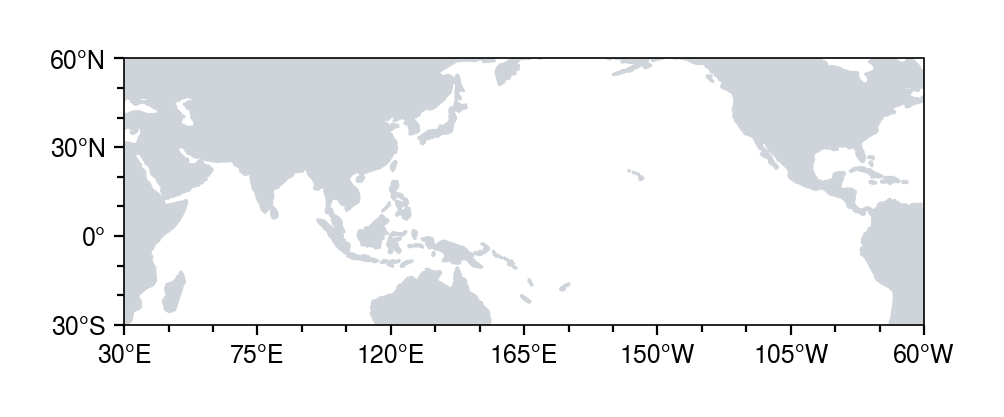

In [16]:
# plot the box
pplt.rc["grid"] = False

cl = 180  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.5, outerpad=2.0)
axs = fig.subplots(ncols=1, nrows=1, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([30, 75, 120, 165, 210, 255, 300])  # 设置纬度刻度
yticks = np.arange(-30, 61, 30)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [xticks[0], xticks[-1], -15, yticks[-1]]
geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=9, latminorspace=10, coastlinewidth=1.0, majorticklabelpad=3.0, majorticklen=3.5, minorticklen=2.5, lonminorspace=15)
# ===================================================
# box_N = 50.0
# box_S = 27.5
# box_W = 105.0
# box_E = 137.5
# NC_N = 40.0
# NC_S = 32.5
# NC_W = 105.0
# NC_E = 120.0
# x0 = NC_W
# y0 = NC_S
# width = NC_E-NC_W
# height = NC_N-NC_S
# sepl.patches(axs, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)

# YZR_S = 25.0
# x0 = NC_W
# y0 = YZR_S
# width = NC_E-NC_W
# height = NC_S-YZR_S
# sepl.patches(axs, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)

# box_N = 22.5
# box_S = 12.5
# box_W = 70
# box_E = 105


# x0 = box_W
# y0 = box_S
# width = box_E-box_W
# height = box_N-box_S
# sepl.patches(axs, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)

# con = axs[0].contourf(
#     hgt,
#     cmap="greys",
#     cmap_kw={"right": 0.94},
#     levels=np.arange(200,5901,100),
#     zorder=0.8,
#     )
# cb = fig.colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8)

fig.format(rc_kw={"grid": False, "reso": "lo", "figure.facecolor":"white", "font.large": 13})
fig.save("/home/ys17-23/chenhj/thesis_fig.svg", dpi=900)

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = li

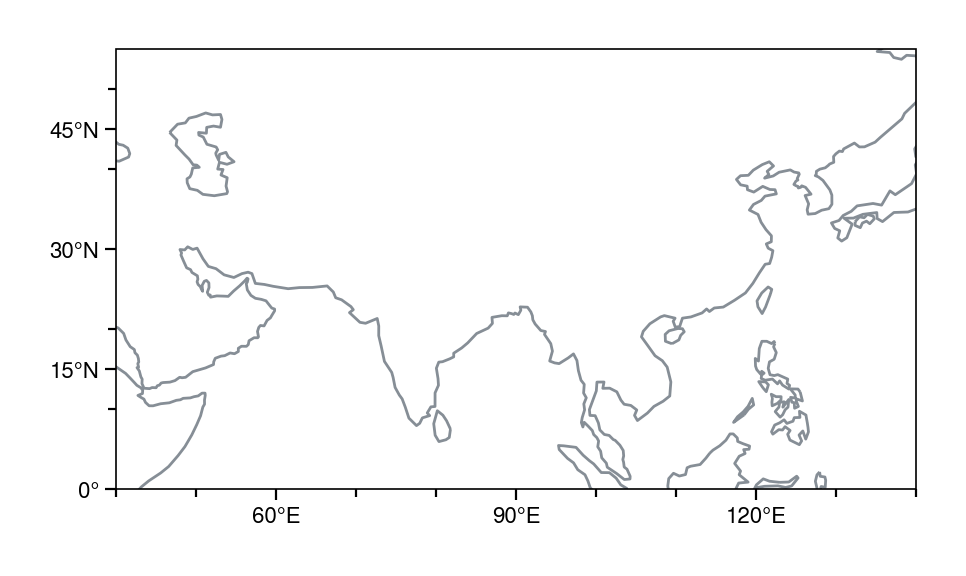

In [17]:
# plot the box
pplt.rc["grid"] = False

cl = 180  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.5, outerpad=2.0)
axs = fig.subplots(ncols=1, nrows=1, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=8, latminorspace=10, coastlinewidth=1.0)
# ===================================================
# box_N = 50.0
# box_S = 27.5
# box_W = 105.0
# box_E = 137.5


# x0 = box_W
# y0 = box_S
# width = box_E-box_W
# height = box_N-box_S
# sepl.patches(axs, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)

# box_N = 22.5
# box_S = 12.5
# box_W = 70
# box_E = 105


# x0 = box_W
# y0 = box_S
# width = box_E-box_W
# height = box_N-box_S
# sepl.patches(axs, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)

# con = axs[0].contourf(
#     hgt,
#     cmap="greys",
#     cmap_kw={"right": 0.94},
#     levels=np.arange(200,5901,100),
#     zorder=0.8,
#     )
# cb = fig.colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8)

fig.format(rc_kw={"grid": False, "reso": "lo", "figure.facecolor":"white", "font.large": 13})

/tmp/ipykernel_3672236/4036781741.py:22: ProplotWarning: Ignoring Proj() keyword arg(s): {'pole_latitude': 90}.
  fig, axs = pplt.subplots(plot_array, figwidth=10, span=True,proj=projs, proj_kw={"pole_latitude":90})
/home/soft/anaconda3/envs/chenhj/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_3672236/4036781741.py:22: ProplotWarning: Ignoring Proj() keyword arg(s): {'pole_latitude': 90}.
  fig, axs = pplt.subplots(plot_array, figwidth=10, span=True,proj=projs, proj_kw={"pole_latitude":90})
/home/soft/anaconda3/envs/chenhj/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_3672236/4036781741.py

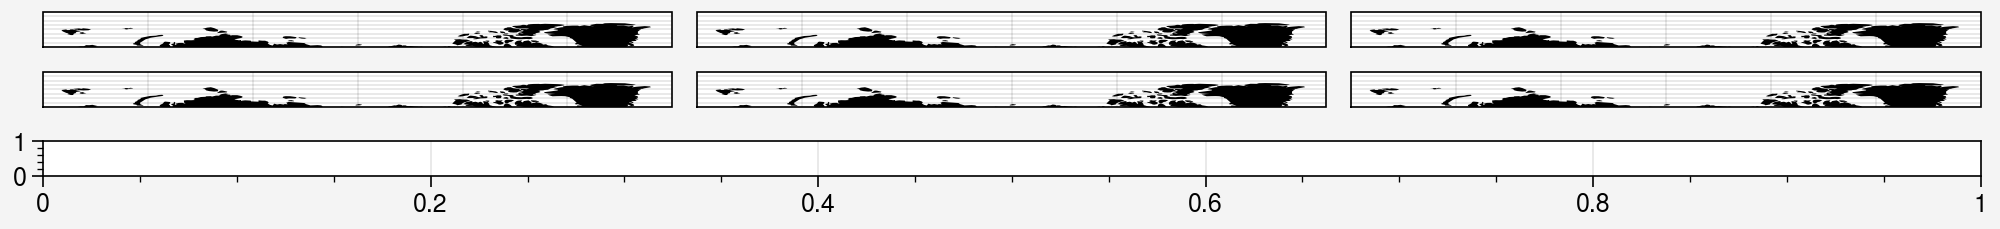

In [5]:
pplt.rc.reset()
pplt.rc['cartopy.circular'] = False
# melt_t = meltin.time
# ttlist = [str(t)[36:40] for t in melt_t]
enso = ['El','-','-','El','La','La','-',\
'El','El','La','-','-','El','-',\
'-','El','La','-','El','La','La',\
'La','-','El','-','El','La','El',\
'La','La','El','La','La','-','-',\
'El','El','-','La','El','-','La'
]
#设置画图行列数，合并最后一行
nrows=3 #行
ncols=3 #列
plot_array = np.reshape(range(1,nrows*ncols+1), (nrows, ncols))
plot_array[-1:, :] = (nrows-1)*ncols+1

projs = [ccrs.RotatedPole()]*nrows*(ncols-1)
projs.extend([None])
# projs.extend(latlim=(10,60))
#basemap = pplt.Proj('splaea', boundinglat=60, basemap=True)
fig, axs = pplt.subplots(plot_array, figwidth=10, span=True,proj=projs, proj_kw={"pole_latitude":90})
# axs[0].format(rc_kw={"geo.round":False})
axs[:-1].format(land=True, latlim=(70,90), lonlim=(0,360))
